# Interaction Network

This jupyter notebook is for implementing a paper [Interaction Networks for Learning about Objects, Relations and Physics](https://arxiv.org/abs/1612.00222) of [Deepmind](https://deepmind.com/). This code will be implemented by [Tensorflow](https://www.tensorflow.org/)

## Import Libraries

In [1]:
import numpy as np 
import scipy.io
import matplotlib.pyplot as plt
import datetime
import os

import torch
import torch.nn.functional as F
import torch.optim as optim

## Parameters

In [2]:
# Parameters of the data
Len_state = 6 # Length of the state
Len_relation = 1 # Length of the relation 
Len_external = 1 # Length of the external effect
Len_effect = 512 # Length of the effect
Len_output = 4 # Length of the output (x position, y position, x velocity y velocity)

Num_obj = 6 # Number of the objects 
Num_relation = Num_obj*(Num_obj-1) # Number of the relations

B_shape = [(2*Len_state) + Len_relation, Num_relation]
C_shape = [(Len_state + Len_external + Len_effect), Num_obj]

# Parameter for training
Num_batch = 512
Num_epoch = 30
Learning_rate = 0.0001

Is_train = True
Load_model = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
date_time = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

save_path = './saved_networks/' + date_time + '/model.ckpt'
load_path = ''

# Parameter for network
fR_dense1 = [B_shape[0], 1024]
fR_dense2 = [1024, 2048]
fR_dense3 = [2048, 1024]
fR_dense4 = [1024, Len_effect]

fO_dense1 = [C_shape[0], 1024]
fO_dense2 = [1024, 2048]
fO_dense3 = [2048, 1024]
fO_dense4 = [1024, Len_output]

## Get data

In [3]:
dataset_train = scipy.io.loadmat('./data/Training_dataset.mat')
dataset_test  = scipy.io.loadmat('./data/Testing_dataset.mat')

data_x = np.float32(dataset_train['X'])
data_y = np.float32(dataset_train['Y'])

data_x_test = dataset_test['X']
data_y_test = dataset_test['Y']

train_data_num = data_x.shape[0]

print("Data_x shape: " + str(data_x.shape))
print("Data_y shape: " + str(data_y.shape))
print("TestData_x shape: " + str(data_x_test.shape))
print("TestData_y shape: " + str(data_y_test.shape))

Data_x shape: (1000000, 6, 6)
Data_y shape: (1000000, 6, 6)
TestData_x shape: (100000, 6, 6)
TestData_y shape: (100000, 6, 6)


## Interaction Network

### IN Network

In [4]:
class Relation_function(torch.nn.Module):
    def __init__(self):
        super(Relation_function, self).__init__()
        
        self.dense_r1 = torch.nn.Linear(fR_dense1[0], fR_dense1[1])
        self.dense_r2 = torch.nn.Linear(fR_dense2[0], fR_dense2[1])
        self.dense_r3 = torch.nn.Linear(fR_dense3[0], fR_dense3[1])
        self.dense_r4 = torch.nn.Linear(fR_dense4[0], fR_dense4[1])
        
    def forward(self, x):
        x = F.relu(self.dense_r1(x))
        x = F.relu(self.dense_r2(x))
        x = F.relu(self.dense_r3(x))
        x = self.dense_r4(x)
        
        return x
    
class Object_function(torch.nn.Module):
    def __init__(self):
        super(Object_function, self).__init__()
        
        self.dense_o1 = torch.nn.Linear(fO_dense1[0], fO_dense1[1])
        self.dense_o2 = torch.nn.Linear(fO_dense2[0], fO_dense2[1])
        self.dense_o3 = torch.nn.Linear(fO_dense3[0], fO_dense3[1])
        self.dense_o4 = torch.nn.Linear(fO_dense4[0], fO_dense4[1])
        
    def forward(self, x):
        x = F.relu(self.dense_o1(x))
        x = F.relu(self.dense_o2(x))
        x = F.relu(self.dense_o3(x))
        x = self.dense_o4(x)
        
        return x        

In [5]:
f_R = Relation_function().to(device)
f_O = Object_function().to(device)

param_fR = list(f_R.parameters())
param_fO = list(f_O.parameters())

optimizer = optim.Adam(param_fR+param_fO, lr=Learning_rate)

if Load_model:
    checkpoint = torch.load(load_path,map_location=device)
    f_R.load_state_dict(checkpoint["fR"])
    f_O.load_state_dict(checkpoint["fO"])

### IN class

In [6]:
class InteractionNetwork:
    def __init__(self):
        pass
    
    def get_batch(self, idx):
        if idx + Num_batch < train_data_num:
            batch_index = [idx, idx + Num_batch]
        else:
            batch_index = [idx, train_data_num-1]

        batch_x = data_x[random_idx[batch_index[0]:batch_index[-1]],:,:]
        batch_y = data_y[random_idx[batch_index[0]:batch_index[-1]], 0:4, :]

        batch_x_val = data_x_test[0:batch_index[1]-batch_index[0], :, :]
        batch_y_val = data_y_test[0:batch_index[1]-batch_index[0], 0:4, :]

        batch_external = np.zeros([batch_index[1]-batch_index[0], Len_external, Num_obj], dtype = np.float32)

        # Relation matrix
        batch_Rr = np.zeros([batch_index[1]-batch_index[0], Num_obj, Num_relation], dtype = np.float32)
        batch_Rs = np.zeros([batch_index[1]-batch_index[0], Num_obj, Num_relation], dtype = np.float32)
        batch_Ra = np.zeros([batch_index[1]-batch_index[0], Len_relation, Num_relation], dtype = np.float32)

        relation_idx = 0
        for m in range(Num_obj):
            for n in range(Num_obj):
                if m != n:
                    batch_Rs[:,m,relation_idx] = 1
                    batch_Rr[:,n,relation_idx] = 1

                    relation_idx = relation_idx + 1  

        batch_x = torch.FloatTensor(batch_x).to(device)
        batch_y = torch.FloatTensor(batch_y).to(device)
        batch_x_val = torch.FloatTensor(batch_x_val).to(device)
        batch_y_val = torch.FloatTensor(batch_y_val).to(device)
        batch_external = torch.FloatTensor(batch_external).to(device)
        
        batch_Rr = torch.FloatTensor(batch_Rr).to(device)
        batch_Rs = torch.FloatTensor(batch_Rs).to(device)
        batch_Ra = torch.FloatTensor(batch_Ra).to(device)
        
        return [batch_x, batch_y, batch_x_val, batch_y_val, batch_external, 
                batch_Rr, batch_Rs, batch_Ra]
    
    def get_relation(self, B):
        e_list = []
    
        for i in range(Num_relation):
            b = B[:,:,i]
            e = f_R(b)
            
            e_list.append(e.unsqueeze(2))
        
        E = torch.cat(e_list, dim=2)

        return E
    
    def get_output(self, C):
        p_list = []
        
        for i in range(Num_obj):
            c = C[:,:,i]
            p = f_O(c)
            
            p_list.append(p.unsqueeze(2))

        P = torch.cat(p_list, dim=2)
        
        return P

## Training

In [ ]:
if Is_train == True:
    for i in range(Num_epoch):
        # Making batches
        random_idx = np.arange(train_data_num)
        np.random.shuffle(random_idx)

        batch_count = 1
        num_batch_data = 0

        train_loss_list = []
        val_loss_list = []

        IN = InteractionNetwork()

        for j in range(0, train_data_num, Num_batch):
            O, y, O_val, y_val, X, Rr, Rs, Ra = IN.get_batch(j)

            ############################ Training ############################
            B = torch.cat((torch.matmul(O, Rr),torch.matmul(O, Rs),Ra), dim=1)

            E = IN.get_relation(B)
            E_bar = torch.matmul(E, torch.transpose(Rr, dim0=1, dim1=2))

            C = torch.cat((O,X,E_bar), axis=1)

            P = IN.get_output(C)

            loss_train = F.mse_loss(P, y)

            train_loss_list.append(loss_train.item())

            ############################ Validation ############################
            B_val = torch.cat((torch.matmul(O_val, Rr),
                               torch.matmul(O_val, Rs),Ra), dim=1)

            E_val = IN.get_relation(B_val)
            E_bar_val = torch.matmul(E_val, torch.transpose(Rr, dim0=1, dim1=2))

            C_val = torch.cat((O_val,X,E_bar_val), axis=1)

            P_val = IN.get_output(C_val)

            loss_val = F.mse_loss(P_val, y_val)

            val_loss_list.append(loss_val.item())
            
            ############################ Optimization ############################
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            
            print("Batch: " + str(j) + '/' + str(train_data_num), end="\r")    

        # Print Progress
        print("Epoch: {} / Train Loss: {:.6f} / Val Loss: {:.6f}".format(
              i+1, np.mean(train_loss_list), np.mean(val_loss_list))) 
    
    # Save Model
    os.makedirs('./saved_networks/' + date_time, exist_ok=True)
    
    torch.save({
        "fR" : f_R.state_dict(),
        "fO" : f_O.state_dict(),
    }, save_path)
    
    print("Model is saved in file: %s" % save_path)

Epoch: 1 / Train Loss: 0.002309 / Val Loss: 0.001895
Epoch: 2 / Train Loss: 0.001096 / Val Loss: 0.000867
Epoch: 3 / Train Loss: 0.001001 / Val Loss: 0.000792
Epoch: 4 / Train Loss: 0.000875 / Val Loss: 0.000691
Epoch: 5 / Train Loss: 0.000492 / Val Loss: 0.000396
Epoch: 6 / Train Loss: 0.000388 / Val Loss: 0.000310
Epoch: 7 / Train Loss: 0.000347 / Val Loss: 0.000275
Epoch: 8 / Train Loss: 0.000327 / Val Loss: 0.000255
Epoch: 9 / Train Loss: 0.000307 / Val Loss: 0.000246
Epoch: 10 / Train Loss: 0.000285 / Val Loss: 0.000228
Epoch: 11 / Train Loss: 0.000265 / Val Loss: 0.000211
Epoch: 12 / Train Loss: 0.000262 / Val Loss: 0.000205
Epoch: 13 / Train Loss: 0.000241 / Val Loss: 0.000195
Epoch: 14 / Train Loss: 0.000242 / Val Loss: 0.000194
Epoch: 15 / Train Loss: 0.000226 / Val Loss: 0.000181
Epoch: 16 / Train Loss: 0.000223 / Val Loss: 0.000184
Epoch: 17 / Train Loss: 0.000215 / Val Loss: 0.000177
Epoch: 18 / Train Loss: 0.000208 / Val Loss: 0.000169
Epoch: 19 / Train Loss: 0.000206 / Va

## Testing

Testing will be carried out for many steps recursively and it will be compared with true values.  

In [26]:
# 1 episode is 1000 steps 
start_step = 70
test_steps = 20

result_list = []

test_x = data_x_test[start_step, :, :]
test_x = test_x.reshape(1, test_x.shape[0], test_x.shape[1])

for i in range(start_step, start_step + test_steps):
    # Set relation and external -> every objects are each other's sender and receiver
    batch_Rr = np.zeros([1, Num_obj, Num_relation], dtype = np.float32)
    batch_Rs = np.zeros([1, Num_obj, Num_relation], dtype = np.float32)
    batch_Ra = np.zeros([1, Len_relation, Num_relation], dtype = np.float32)

    batch_external = np.zeros([1, Len_external, Num_obj], dtype = np.float32)

    relation_idx = 0
    for m in range(Num_obj):
        for n in range(Num_obj):
            if m != n:
                batch_Rs[:,m,relation_idx] = 1
                batch_Rr[:,n,relation_idx] = 1

                relation_idx = relation_idx + 1   
    
    O = torch.FloatTensor(test_x).to(device)
    X = torch.FloatTensor(batch_external).to(device)

    Rr = torch.FloatTensor(batch_Rr).to(device)
    Rs = torch.FloatTensor(batch_Rs).to(device)
    Ra = torch.FloatTensor(batch_Ra).to(device)
    
    with torch.no_grad():
        B = torch.cat((torch.matmul(O, Rr),torch.matmul(O, Rs),Ra), dim=1)

        E = IN.get_relation(B)
        E_bar = torch.matmul(E, torch.transpose(Rr, dim0=1, dim1=2))

        C = torch.cat((O,X,E_bar), axis=1)

        P = IN.get_output(C)

        output = P.detach().cpu().numpy()
    
    result_list.append(output)
    
    next_input = np.zeros([1, Len_state, Num_obj])
    next_input[:, 0:Len_output, :] = output
    next_input[:, Len_output: , :] = test_x[:, Len_output: , :]
    
    test_x = next_input

pos_x_list = []
pos_y_list = []
true_pos_x_list = []
true_pos_y_list = []

for i in range(Num_obj):
    pos_x_list.append([])
    pos_y_list.append([])
    true_pos_x_list.append([])
    true_pos_y_list.append([])

for i in range(start_step, start_step + test_steps):
    for j in range(Num_obj):
        pos_x_list[j].append(result_list[i-start_step][0,0,j])
        pos_y_list[j].append(result_list[i-start_step][0,1,j])
        true_pos_x_list[j].append(data_y_test[i,0,j])
        true_pos_y_list[j].append(data_y_test[i,1,j])



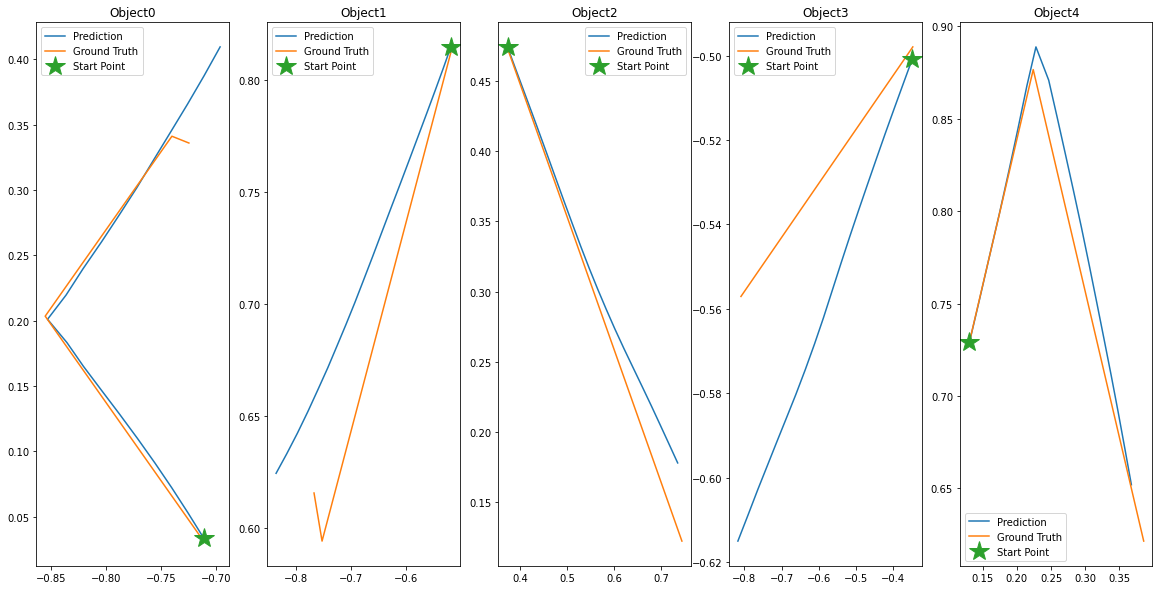

In [27]:
plt.figure(figsize=(20,10))
for i in range(Num_obj-1):
    plt.subplot(1,5,i+1)

    plt.plot(pos_x_list[i], pos_y_list[i], label='Prediction')
    plt.plot(true_pos_x_list[i], true_pos_y_list[i], label='Ground Truth')
    plt.plot(pos_x_list[i][0], pos_y_list[i][0], '*', markersize=20, label='Start Point')
    plt.title('Object' + str(i))
    plt.legend()